In [21]:
%matplotlib inline

import glob
import os

from plot_utils import load_sacred_pickle

import cloudpickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import seaborn as sns
import json

from ray import tune
import skopt
from skopt.plots import plot_evaluations, plot_objective

sns.set(context='notebook', style='darkgrid')

ray_tune_dir = '../runs/tune_runs/12/'
RUNNING_RAY_TUNE_DIR = os.path.join(ray_tune_dir, 'tune_search')

In [22]:
search_alg_pattern = os.path.join(RUNNING_RAY_TUNE_DIR, 'search-alg-*.pkl')
pickle_paths = glob.glob(search_alg_pattern)
if not pickle_paths:
    raise IOError(
        "Could not find any matches for skopt state pattern, "
        f"{search_alg_pattern!r}. Check whether skopt's .pkl file actually "
        f"exists in RUNNING_RAY_TUNE_DIR={RUNNING_RAY_TUNE_DIR!r}.")
pickle_path, = pickle_paths
with open(pickle_path, 'rb') as fp:
    _, skopt_alg = load_sacred_pickle(fp)
    
# If variable names have not been saved and you have to add them back in, you can do something like this:
# variable_names = ['foo', 'bar', 'baz', 'spam', 'ham', 'asdf']
# for var_name, var in zip(variable_names, skopt_alg.space.dimensions):
#     var.name = var_name

skopt_res = skopt_alg.get_result()

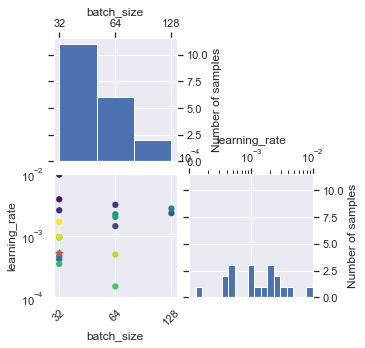

In [23]:
_ = plot_evaluations(skopt_res)

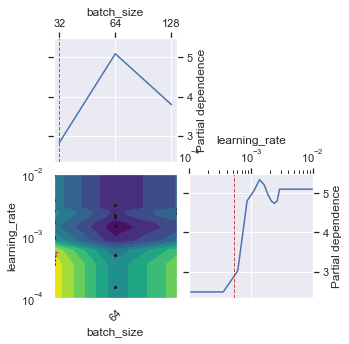

In [26]:
_ = plot_objective(skopt_res)

/Users/cynthiachen/opt/miniconda3/envs/invest/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cynthiachen/opt/miniconda3/envs/invest/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


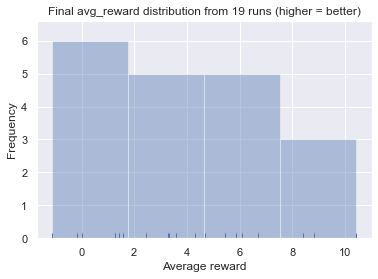

In [30]:
n_results = len(skopt_res.func_vals)
sns.distplot(skopt_res.func_vals, rug=True, norm_hist=False, kde=False, bins=10 if n_results >= 20 else None)
plt.title(f"Final avg_reward distribution from {n_results} runs (higher = better)")
plt.xlabel("Average reward")
plt.ylabel("Frequency")
plt.show()

In [32]:
# we plot any config that has loss below 'thresh'
# (by default, I've made it show the top 10 best configs;
# you can change 'thresh' to anything you want)
thresh = min(sorted(skopt_res.func_vals)[-5:])
good_inds, = np.nonzero(skopt_res.func_vals >= thresh)
for conf_num, good_ind in enumerate(good_inds, start=1):
    print(
        f"Good config at index {good_ind} ({conf_num}/"
        f"{len(good_inds)}), thresh {thresh}:")
    # TODO: print function value here too
    all_dims = skopt_res.space.dimensions
    for dim, value in zip(all_dims, skopt_res.x_iters[good_ind]):
        print(f'    {dim.name} = {value}')
        
print(f'Amalgamated "good" configs at thresh {thresh}:')
for dim_idx, dimension in enumerate(skopt_res.space.dimensions):
    values = [skopt_res.x_iters[i][dim_idx] for i in good_inds]
    if isinstance(values[0], float):
        values_str = f"[{', '.join('%.3g' % v for v in values)}]"
    else:
        values_str = str(values)
    print(f'    {dimension.name} = {values_str}')

Good config at index 0 (1/5), thresh 6.103999999999999:
    batch_size = 32
    learning_rate = 0.009719976423887753
Good config at index 3 (2/5), thresh 6.103999999999999:
    batch_size = 64
    learning_rate = 0.0031443147625149965
Good config at index 4 (3/5), thresh 6.103999999999999:
    batch_size = 64
    learning_rate = 0.0014193067938133013
Good config at index 15 (4/5), thresh 6.103999999999999:
    batch_size = 32
    learning_rate = 0.0009279690200860529
Good config at index 16 (5/5), thresh 6.103999999999999:
    batch_size = 64
    learning_rate = 0.0004922841707491923
Amalgamated "good" configs at thresh 6.103999999999999:
    batch_size = [32, 64, 64, 32, 64]
    learning_rate = [0.00972, 0.00314, 0.00142, 0.000928, 0.000492]
